In [2]:
import pandas as pd

import numpy as np

import statsmodels.formula.api as smf

In [3]:
management_training_url = 'https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/management_training.csv'

df = pd.read_csv(management_training_url)
df.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843


# Adjust with regression

In [4]:
smf.ols('engagement_score ~ intervention', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2347,0.014,-16.619,0.000,-0.262,-0.207
intervention,0.4346,0.019,22.616,0.000,0.397,0.472


In [5]:
model = smf.ols('''engagement_score ~ intervention + tenure +
                last_engagement_score + department_score +
                n_of_reports + C(gender) + C(role)''', data=df).fit()

print("ATE: ", model.params["intervention"])
print("95% CI: ", model.conf_int().loc["intervention", :].values.T)

ATE:  0.267790857667686
95% CI:  [0.23357751 0.30200421]


# Propensity Score Estimation

In [6]:
ps_model = smf.logit("""intervention ~ tenure +
    last_engagement_score + department_score +
    C(n_of_reports) + C(gender) + C(role)""",
    data=df).fit(disp=0) # disp controla verbosity

data_ps = df.assign(
    propensity_score = ps_model.predict(df)
)

data_ps[["intervention", "engagement_score", "propensity_score"]].head()

,intervention,engagement_score,propensity_score
0,1,0.277359,0.596106
1,1,-0.449646,0.391138
2,1,0.769703,0.602578
3,1,-0.121763,0.580990
4,1,1.526147,0.619976


In [7]:
model = smf.ols("engagement_score ~ intervention + propensity_score", data=data_ps).fit()
model.params["intervention"]

0.26331267490277316

## Propensity Score Matching

In [8]:
from sklearn.neighbors import KNeighborsRegressor

T = "intervention"
X = "propensity_score"
Y = "engagement_score"

treated = data_ps.query(f"{T}==1")
untreated = data_ps.query(f"{T}==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[[X]], untreated[Y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[[X]], treated[Y])

predicted = pd.concat([
    # Matches para Tratado procurando modelo não tratado
    treated.assign(match=mt0.predict(treated[[X]])),

    # Matches para Não Tratado procurando modelo tratado
    untreated.assign(match=mt1.predict(untreated[[X]]))
    
    ])

np.mean((predicted[Y] - predicted["match"]) * predicted[T] + (predicted["match"] - predicted[Y]) * (1 - predicted[T]))




0.28777443474045966

## Inverse Propensity Weighting

In [21]:
weight_t = 1 / data_ps.query("intervention==1")["propensity_score"]
#prob de nao tratamento = 1 - prob de tratamento
weight_nt = 1 / (1 - data_ps.query("intervention==0")["propensity_score"])

t1 = data_ps.query("intervention==1")["engagement_score"]
t0 = data_ps.query("intervention==0")["engagement_score"]

y1 = sum(t1 * weight_t) / len(data_ps)
y0 = sum(t0 * weight_nt) / len(data_ps)

print(f"E[Y1]: {y1}")
print(f"E[Y0]: {y0}")
print(f"ATE: {y1 - y0}")

E[Y1]: 0.1165631723294695
E[Y0]: -0.1494155364781463
ATE: 0.26597870880761576


In [28]:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix

def est_ate_with_ps(df, ps_formula, T, Y):
    X = dmatrix(ps_formula, df)
    ps_model = LogisticRegression(penalty="none", max_iter=1_000).fit(X, df[T])
    ps = ps_model.predict_proba(X)[:, 1]

    return np.mean((df[T]- ps) / (ps * (1 - ps)) * df[Y])


formula = """tenure + last_engagement_score + department_score +
C(n_of_reports) + C(gender) + C(role)"""
T = "intervention"
Y = "engagement_score"

est_ate_with_ps(df, formula, T, Y)

0.2660335522535528

In [30]:
import os
os.cpu_count()

10

In [34]:
from toolz import partial
from joblib import Parallel, delayed

def bootstrap(data,
              est_fn,
              rounds=200,
              seed=123,
              pcts=[2.5, 97.5]):
    
    np.random.seed(seed)

    stats = Parallel(n_jobs=10)(
        delayed(est_fn)(data.sample(frac=1, replace=True))
        for _ in range(rounds)
    )

    return np.percentile(stats, pcts)

# `partial` cria funcao, restando unicamente assign df
est_fn = partial(est_ate_with_ps, ps_formula=formula, T=T, Y=Y)
print(f"95% CI: ", bootstrap(df, est_fn))


95% CI:  [0.22661673 0.30075822]


In [35]:
p_of_t = data_ps["intervention"].mean()

t1 = data_ps.query("intervention==1")
t0 = data_ps.query("intervention==0")

weight_t_stable = p_of_t / t1["propensity_score"]
weight_nt_stable = (1 - p_of_t) / (1 - t0["propensity_score"])

print("Treat size: ", len(t1))
print("W treat", sum(weight_t_stable))

print("Control sie", len(t0))
print("W treat", sum(weight_nt_stable))

Treat size:  5611
W treat 5634.807508745969
Control sie 4780
W treat 4763.116999421412


<Axes: xlabel='propensity_score', ylabel='Count'>

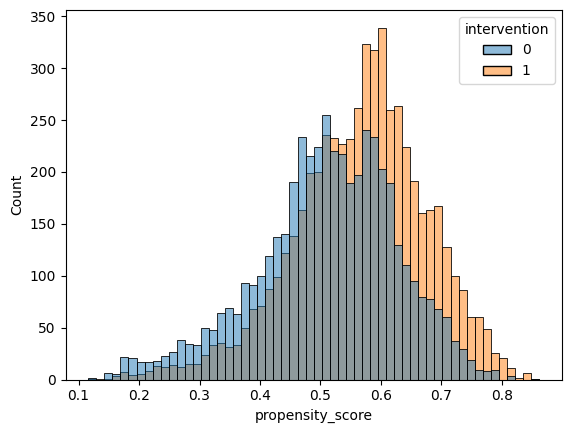

In [37]:
import seaborn as sns

sns.histplot(data=data_ps, x="propensity_score", hue="intervention")

# Doubly Robust

In [45]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust(df, formula, T, Y):

    X = dmatrix(formula, df)

    ps_model = LogisticRegression(penalty="none", max_iter=1_000).fit(X, df[T])
    ps = ps_model.predict_proba(X)[:, 1]

    m0 = LinearRegression().fit(X[df[T]==0,:], df.query(f"{T} == 0")[Y])
    m1 = LinearRegression().fit(X[df[T]==1, :], df.query(f"{T} == 1")[Y]) 

    m0_hat = m0.predict(X)
    m1_hat = m1.predict(X)

    return (
        np.mean(
            df[T] * (df[Y] - m1_hat) / ps + m1_hat
            ) -
        np.mean(
            (1 - df[T]) * (df[Y] - m0_hat) / (1 - ps) + m0_hat
            )
        )

In [47]:
formula= """tenure + last_engagement_score + department_score + C(n_of_reports) + C(gender) + C(role)"""
T = "intervention"
Y = "engagement_score"

print(f"DR ATE: {doubly_robust(df, formula, T, Y)}")

est_fn = partial(doubly_robust, formula=formula, T=T, Y=Y)
print("95% CI", bootstrap(df, est_fn=est_fn))

DR ATE: 0.2711545411906764
95% CI [0.23014098 0.30524714]


## Treatment is easy to model

In [52]:
np.random.seed(123)

# Processo gerador dos dados
n = 10_000
x = np.random.beta(1, 1, n).round(2)*2
e = 1 / (1 + np.exp(-(1 + 1.5 * x)))
t = np.random.binomial(1, e)

y1= 1
y0 = 1 - 1 * x**3 #ols encontrará problema
y = t * (y1) + (1 - t) * y0 + np.random.normal(0, 1, n)

df_easy_t = pd.DataFrame(dict(y=y, x=x, t=t))
print(f"True ATE: {np.mean(y1 - y0)}")

True ATE: 2.0056243152


In [69]:
# Verificar regressao
m0 = smf.ols("y ~ x", data=df_easy_t.query("t==0")).fit()
m1 = smf.ols("y ~ x", data=df_easy_t.query("t==1")).fit()

regr_ate = (m1.predict(df_easy_t) - m0.predict(df_easy_t)).mean()

# OLS falha em capturar ATE
regr_ate 

1.78667839683302

In [72]:
# verificar e_X

est_fn = partial(est_ate_with_ps, ps_formula="x", T="t", Y="y")

#  Propensity score consegue
print("Propensity Score ATE:", est_fn(df_easy_t))

print(f"95% CI: {bootstrap(df_easy_t, est_fn)}")

Propensity Score ATE: 2.002350388474011
95% CI: [1.80802227 2.22565667]


In [86]:
# Usando DR
est_fn = partial(doubly_robust, formula="x", T="t", Y="y")
print(f"ATE with DR: {est_fn(df_easy_t)}")
print(f"IC-95 with DR: {bootstrap(df_easy_t, est_fn=est_fn)}")

ATE with DR: 2.001617934263116


IC-95 with DR: [1.87088771 2.145382  ]


## Outcome is Easy to model

In [101]:
np.random.seed(123)

n = 10_000
x = np.random.beta(1, 1, n).round(2) * 2
e = 1 / (1 + np.exp(- (2 * x - x**3)))
t = np.random.binomial(1, e)

y1 = x
y0 = y1 + 1 # ate = -1
y = t*(y1) + (1 - t) * y0 + np.random.normal(0, 1, n)

df_easy_y = pd.DataFrame(dict(x=x, y=y, t=t))

print(f"True ATE: {(y1-y0).mean()}")

True ATE: -1.0


<Axes: xlabel='x', ylabel='y'>

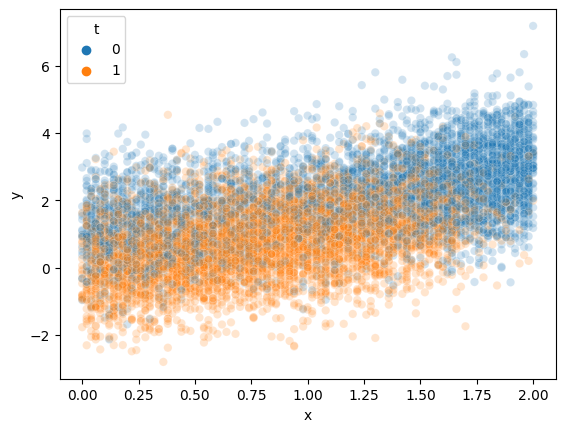

In [107]:
sns.scatterplot(df_easy_y, x="x", y="y", hue="t", alpha=.2)

In [108]:
#IPW
est_fn = partial(est_ate_with_ps, ps_formula="x", T="t", Y="y")
print(f"Propensity Score ATE: {est_fn(df_easy_y)}")
print(f"IC-95 IPW: {bootstrap(df_easy_y, est_fn)}")

Propensity Score ATE: -1.1042900278680894
IC-95 IPW: [-1.14326893 -1.06576358]


In [111]:
#Reg
m1 = smf.ols("y ~ x", data=df_easy_y.query("t == 1")).fit()
m0 = smf.ols("y ~ x", data=df_easy_y.query("t == 0")).fit()

(m1.predict(df_easy_y) - m0.predict(df_easy_y)).mean()

-1.0008783612504364

In [113]:
#DR
est_fn = partial(doubly_robust, formula="x", T="t", Y="y")
print(f"ATE DR: {est_fn(df_easy_y)}")
print(f"IC-95 DR: {bootstrap(data=df_easy_y, est_fn=est_fn)}")

ATE DR: -1.002845934780583


IC-95 DR: [-1.04156952 -0.96353366]


# Generalized Propensity Score for Continuous Treatment

In [115]:
df_cont_t = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/interest_rate.csv")
df_cont_t.head()

,ml_1,ml_2,interest,duration
0,0.392938,0.326285,7.1,12.0
1,-0.427721,0.679573,5.6,17.0
2,-0.546297,0.647309,11.1,12.0
3,0.102630,-0.264776,7.2,18.0
4,0.438938,-0.648818,9.5,19.0


In [117]:
m_naive = smf.ols("duration ~ interest", data=df_cont_t).fit()
m_naive.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.5033,0.226,64.283,0.000,14.061,14.946
interest,0.3393,0.029,11.697,0.000,0.282,0.396


In [118]:
model_t = smf.ols("interest ~ ml_1 + ml_2", data=df_cont_t).fit()

In [121]:
def conditional_density(x, mean, std):
    denom = std * np.sqrt(2 * np.pi)
    num = np.exp(-(1 / 2) * ( (x - mean) / std) ** 2)

    return (num / denom).ravel()

conditional_density(df_cont_t["interest"], model_t.fittedvalues, np.std(model_t.resid))

array([0.1989118 , 0.14524168, 0.03338421, ..., 0.07339096, 0.19365006,
       0.15732008])

In [122]:
from scipy.stats import norm

gps = norm(loc=model_t.fittedvalues, scale=np.std(model_t.resid)).pdf(df_cont_t["interest"])

In [129]:
final_model = smf.wls("duration ~ interest", data=df_cont_t, weights=1 / gps).fit()
final_model.params["interest"]

-0.6673977919925818

In [133]:
stabilizer = norm(
    loc = df_cont_t["interest"].mean(),
    scale = np.std(df_cont_t["interest"] - np.std(df_cont_t["interest"].mean()))
).pdf(df_cont_t["interest"])

gipw = stabilizer / gps

In [135]:
smf.wls("duration ~ interest", data=df_cont_t, weights= stabilizer / gps).fit().params["interest"]

-0.7787046278134061